Audience Decoder Project

This notebook analyzes, using unsupervised learning techniques, data of user-movie interaction to explore the behavior and identify disitinct profiles.

Einvoirment setup and libraries

We import the Python libraries required and set parameters to ensure a consistent visualtization and reproducibility.

In [274]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

import sqlite3 

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use("default")
plt.rcParams["figure.figsize"] = (8, 5)

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.3f}".format)


Data loading

We load the dataset from a SQLite database into a pandad DataFrame.

In [275]:
db_path = "viewer_interactions.db"
connection = sqlite3.connect(db_path)
query = """
SELECT *
FROM viewer_ratings
"""
df = pd.read_sql_query(query, connection)
connection.close()

df.head()

,movie_id,customer_id,rating,date,anomalous_date
0,17,1481737,3.000,2005-10-09,NaN
1,9236,1448424,5.000,2005-11-15,NaN
2,4640,2308980,NaN,2005-08-06,NaN
3,9330,674346,3.000,2005-04-29,NaN
4,4570,1304045,4.000,2005-09-19,NaN


Data understanding and cleaning

We inspect the structure of the dataset and apply minimal cleaning steps, including type conversion and duplicate removal.

In [ ]:
df.info()
df.isna().sum()

df = df.drop_duplicates()

df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df["date"] = pd.to_datetime(df["date"], errors="coerce")

df = df.dropna(subset=["customer_id", "movie_id", "rating"])
df.shape
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4025000 entries, 0 to 4024999
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   movie_id        int64  
 1   customer_id     int64  
 2   rating          float64
 3   date            object 
 4   anomalous_date  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 153.5+ MB


,movie_id,customer_id,rating,date,anomalous_date
0,17,1481737,3.000,2005-10-09,NaN
1,9236,1448424,5.000,2005-11-15,NaN
3,9330,674346,3.000,2005-04-29,NaN
4,4570,1304045,4.000,2005-09-19,NaN
5,9320,1036533,5.000,2004-08-05,NaN


Exploratory Data Analysis (EDA)

We explore the distribution of ratings, user activity levels and movie popularity to gain initial insights into the dataset.

Rating distribution

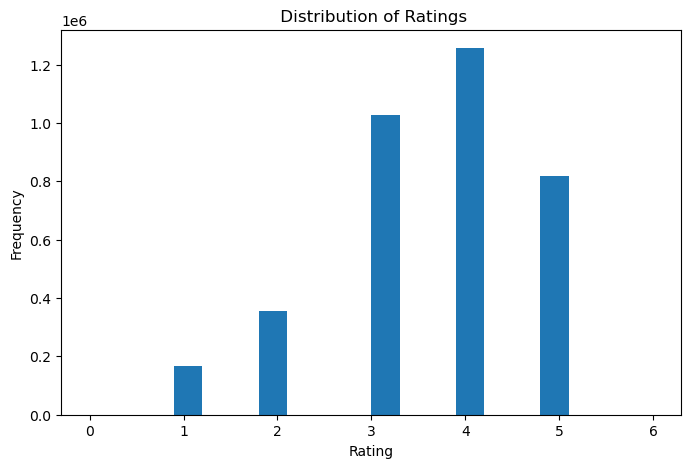

In [ ]:
plt.figure(figsize = (8, 5))
plt.hist(df["rating"], bins = 20)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title(" Rating distribution")
plt.show()

User activity distribution

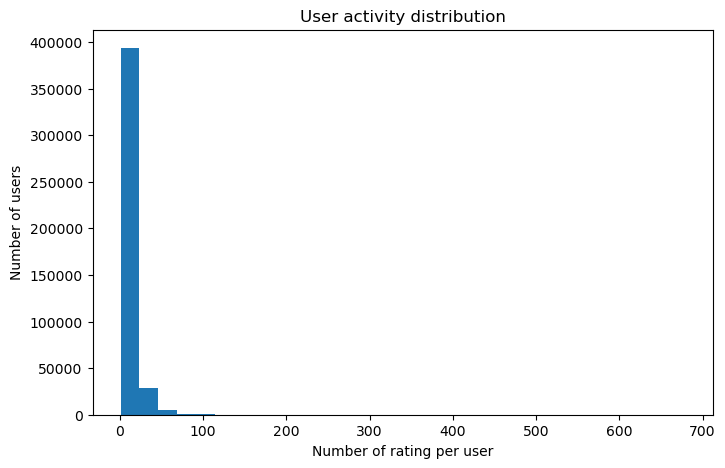

In [278]:
user_activity = df.groupby("customer_id"). size()

plt.figure(figsize = (8, 5))
plt.hist(user_activity, bins = 30)
plt.xlabel("Number of rating per user")
plt.ylabel("Number of users")
plt.title("User activity distribution")
plt.show()


Movie popularity distribution

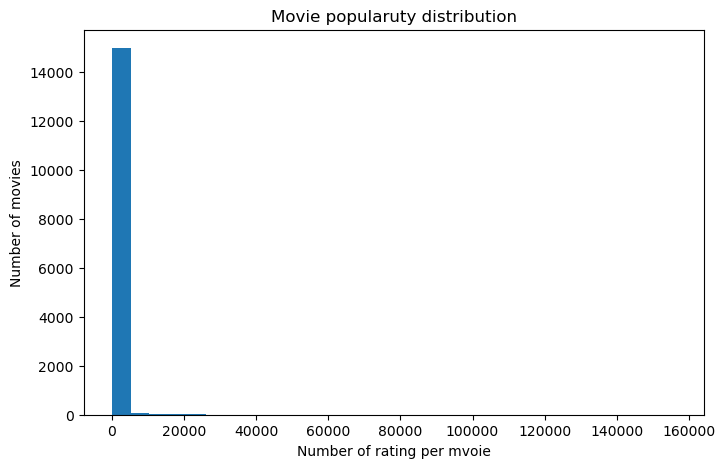

In [279]:
movie_popularity = df.groupby("movie_id").size()

plt.figure(figsize = (8, 5))
plt.hist(movie_popularity, bins = 30)
plt.xlabel("Number of rating per mvoie")
plt.ylabel("Number of movies")
plt.title("Movie popularuty distribution")
plt.show()

Temporal evolution of ratings

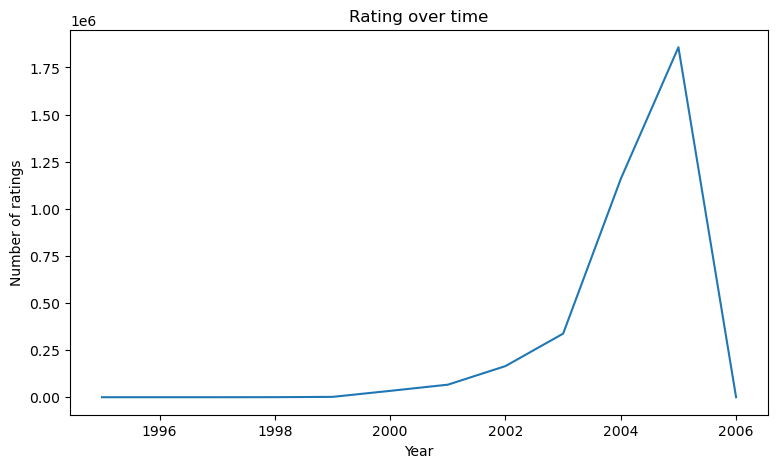

In [280]:
df["year"] = df["date"].dt.year

ratings_per_year = df.groupby("year").size()

plt.figure(figsize = (9, 5))
ratings_per_year.plot()
plt.xlabel("Year")
plt.ylabel("Number of ratings")
plt.title("Rating over time")
plt.show()

USer-level feature engineering

We aggregate the inteeraction data at the user level to build behavioral profiles. For each user, we compute satistics describing rating activity and preferences.

In [281]:
user_features = df.groupby("customer_id").agg(
    n_ratings = ("rating", "count"),
    mean_rating = ("rating", "mean"),
    min_rating = ("rating", "min"), 
    max_rating = ("rating", "max"), 
    unique_movies = ("movie_id", "unique")


)
type(user_features), user_features.shape
user_features.head()

,n_ratings,mean_rating,min_rating,max_rating,unique_movies
customer_id,,,,,
6,24,3.667,2.000,5.000,"[13378, 9426, 4661, 4577, 173, 13462, 197, 134..."
7,34,4.441,3.000,5.000,"[185, 191, 13388, 4669, 4577, 4507, 8, 9229, 1..."
8,3,4.000,3.000,5.000,"[9254, 9340, 9415]"
10,9,3.667,2.000,5.000,"[9340, 13462, 13391, 4633, 197, 191, 4661, 464..."
25,3,3.667,3.000,5.000,"[178, 9326, 4656]"


We inspect the data types of the engineered user features to cofirm thta numerical variable are correctley identified and suitable for scaling and clustering.

In [282]:
user_features.dtypes

n_ratings          int64
mean_rating      float64
min_rating       float64
max_rating       float64
unique_movies     object
dtype: object

Selection of numerical features

We select the numerical user-level featres to be used for scaling and clustering. All selected features are then converted to numeric format to avoid type related errors.

In [283]:
features = [
    "n_ratings",
    "mean_rating",
    "min_rating",
    "max_rating",
]
for col in features:
    user_features[col] = pd.to_numeric(user_features[col], errors="coerce")

X = user_features[features].values
X.shape


(429081, 4)

Feature scaling

We standardize the aelelcted numerical features using StandarScaler to ensure that all variables contribute equally to subsequent analyses.

In [284]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape

(429081, 4)

We inspect the summary statistics of the scaled features to verify that they are centered around zero  and have unit variance

In [285]:
pd.DataFrame(X_scaled, columns = features).describe()

,n_ratings,mean_rating,min_rating,max_rating
count,429081.000,429081.000,429081.000,429081.000
mean,0.000,0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000
min,-0.634,-4.445,-2.166,-4.748
25%,-0.549,-0.573,-0.524,-0.428
50%,-0.378,0.070,0.297,0.653
75%,0.133,0.447,0.297,0.653
max,57.007,2.893,2.760,1.733


Dimensionality reduction with PCA

We apply Principal Component Analysis (PCA) to reduce the diensionaluty of the features space and visualize user profiles ina two-dimensional space.

In [286]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)

X_pca.shape

(429081, 2)

We also inspect the proportion of variance explained by the principal components

In [287]:
pca.explained_variance_ratio_
pca.explained_variance_ratio_.sum()

0.8804563754255293

The PCA scatter plot illustrates the overall structure of user profiles in the reduced feature space.

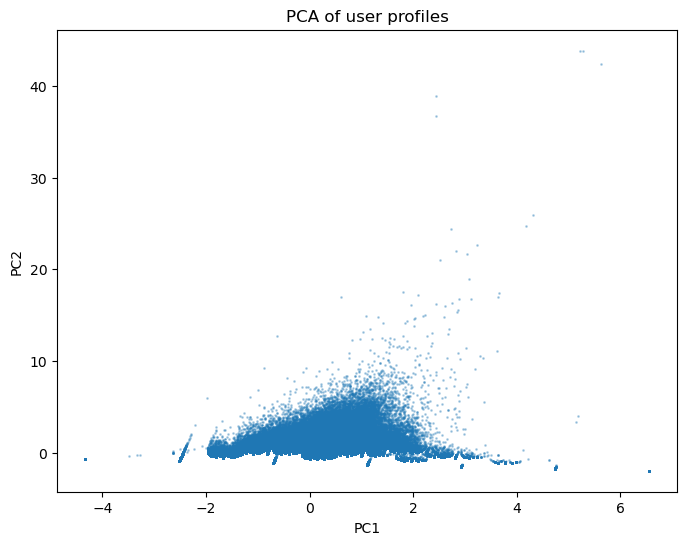

In [288]:
plt.figure(figsize = (8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s =1, alpha = 0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of user profiles")
plt.show()

Clustering

We apply KMeans clusterig to the scaled user feature matrix to identify grorups of users with similar rating behavior

Elbow method 

We use the elbow method to select a reasonable number of cluster by analyzing the within-cluster sum of squares for different values of clusters (k).

In [289]:
inertias = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

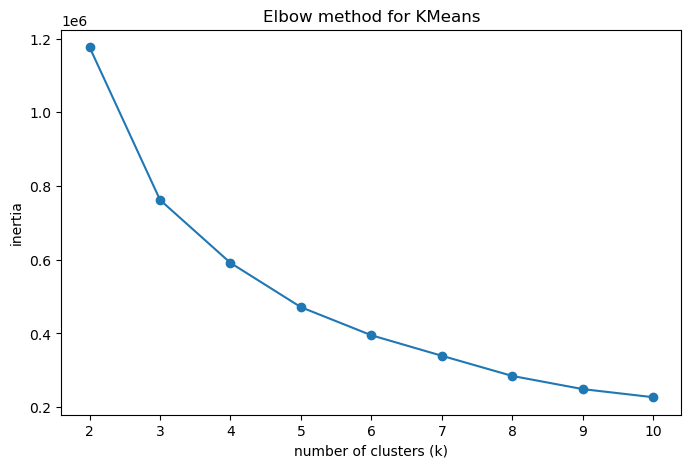

In [290]:
plt.figure(figsize = (8, 5))
plt.plot(K, inertias, marker = "o")
plt.xlabel("number of clusters (k)")
plt.ylabel("inertia")
plt.title("Elbow method for KMeans")
plt.show()

The plot shows a clear decrease in inertia as the number of clusters increases. After k = 4, the improvemnet becomes less pronounced, suggesting diminishing return from adding more clusters.

Based on the elbow method we select k = 4 clusters as a good balance between model simplicity and explanatory power.

In [291]:
kmeans = KMeans(n_clusters = 4, random_state = 42, n_init = 10)
cluster_labels = kmeans.fit_predict(X_scaled)

cluster_labels.shape

(429081,)

Cluster visualization

We visualize the Kmeans clusters in the PCA space to better understand how user profiles are distributed across clusters.

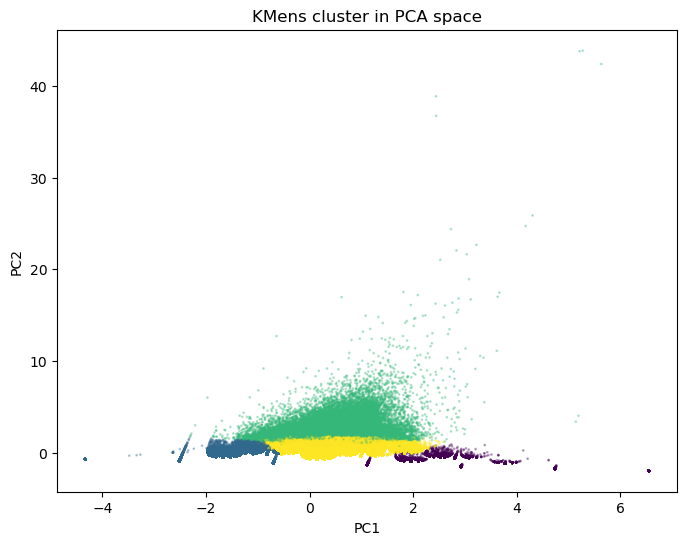

In [296]:
plt.figure(figsize = (8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1],c=cluster_labels, s = 1, alpha = 0.3)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMens cluster in PCA space")
plt.show()

Cluster interpratation 

We analyze the average feature vakues for each cluster to interpret and describe the different user profiles.

In [297]:
clustered_users = user_features.copy()
clustered_users["cluster"] = cluster_labels

clustered_users.groupby("cluster").mean(numeric_only = True)

,n_ratings,mean_rating,min_rating,max_rating
cluster,,,,
0,1.607,2.331,2.184,2.466
1,3.800,4.371,3.904,4.751
2,36.869,3.544,1.510,4.939
3,8.522,3.447,1.935,4.609


Top findings

This section summarizes the main differences between the identified user clusters showing behavioral patterns.

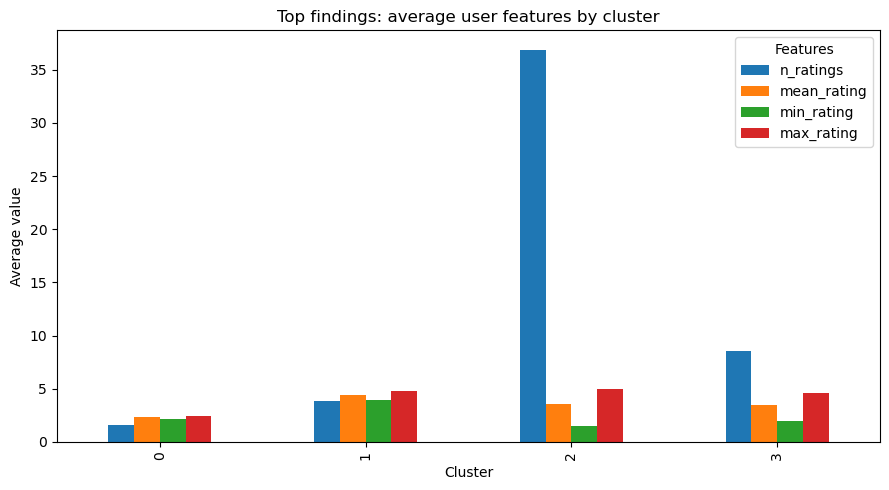

In [298]:
cluster_summary = clustered_users.groupby("cluster")[features].mean()

cluster_summary.plot(kind="bar", figsize=(9, 5))
plt.xlabel("Cluster")
plt.ylabel("Average value")
plt.title("Top findings: average user features by cluster")
plt.legend(title="Features")
plt.tight_layout()
plt.show()
